## **Model 20:  ResNet50 (fine-tune last 20 layers)**

**IMG_SIZE → (224, 224) (instead of (128,128)) because MobileNetV2, ResNet50, EfficientNetB0 all expect (224,224,3) input.**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# Use 224x224 for transfer learning
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Load datasets first (raw, no normalization yet)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Save class names before mapping
class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# Now split validation
val_size = int(0.2 * len(raw_train_ds))
val_ds = raw_train_ds.take(val_size)
train_ds = raw_train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds  = raw_test_ds.map(lambda x,y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


**Number of classes = inferred automatically from dataset**

In [2]:
NUM_CLASSES = len(class_names)

**Load ResNet50 and build model**

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load ResNet50 base, without the top classifier
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Unfreeze the last 20 layers, keep the rest frozen
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation="softmax")(x)

# Build final model
model20 = Model(inputs=base_model.input, outputs=predictions)

# Compile (smaller learning rate for fine-tuning)
model20.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",  # integer labels
    metrics=["accuracy"]
)

**Callbacks**

In [4]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("models/model20_best.keras", monitor="val_loss", save_best_only=True)
]


**Train**

In [5]:
history20 = model20.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 228s 769ms/step - accuracy: 0.5358 - loss: 1.0907 - val_accuracy: 0.5827 - val_loss: 1.1987 - learning_rate: 1.0000e-05
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 222s 777ms/step - accuracy: 0.7157 - loss: 0.7137 - val_accuracy: 0.8187 - val_loss: 0.4875 - learning_rate: 1.0000e-05
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 219s 765ms/step - accuracy: 0.7701 - loss: 0.5914 - val_accuracy: 0.8398 - val_loss: 0.4134 - learning_rate: 1.0000e-05
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 206s 722ms/step - accuracy: 0.8075 - loss: 0.5005 - val_accuracy: 0.8433 - val_loss: 0.3861 - learning_rate: 1.0000e-05
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 200s 701ms/step - accuracy: 0.8315 - loss: 0.4338 - val_accuracy: 0.8662 - val_loss: 0.3494 - learning_rate: 1.0000e-05
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 206s 719ms/step - accuracy: 0.8525 - loss: 0.3794 - val_accuracy: 0.8768 - val_loss: 0.3256 - learning_rate: 1.0000e-05
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 

**Best model**

In [6]:
best_model19 = tf.keras.models.load_model("models/model20_best.keras")

**Evaluate**

In [7]:
from eval import evaluate_model
# Evaluate Model 19
evaluate_model(model20, history20,
                test_ds, "ResNet50 (frozen base, train classifier head)")

ResNet50 (frozen base, train classifier head) - Test accuracy: 0.8963
ResNet50 (frozen base, train classifier head) - Test loss: 0.3093
ResNet50 (frozen base, train classifier head) - Final training accuracy: 0.9939
ResNet50 (frozen base, train classifier head) - Final training loss: 0.0330
ResNet50 (frozen base, train classifier head) - Final validation accuracy: 0.9181
ResNet50 (frozen base, train classifier head) - Final validation loss: 0.3023


**Plot**

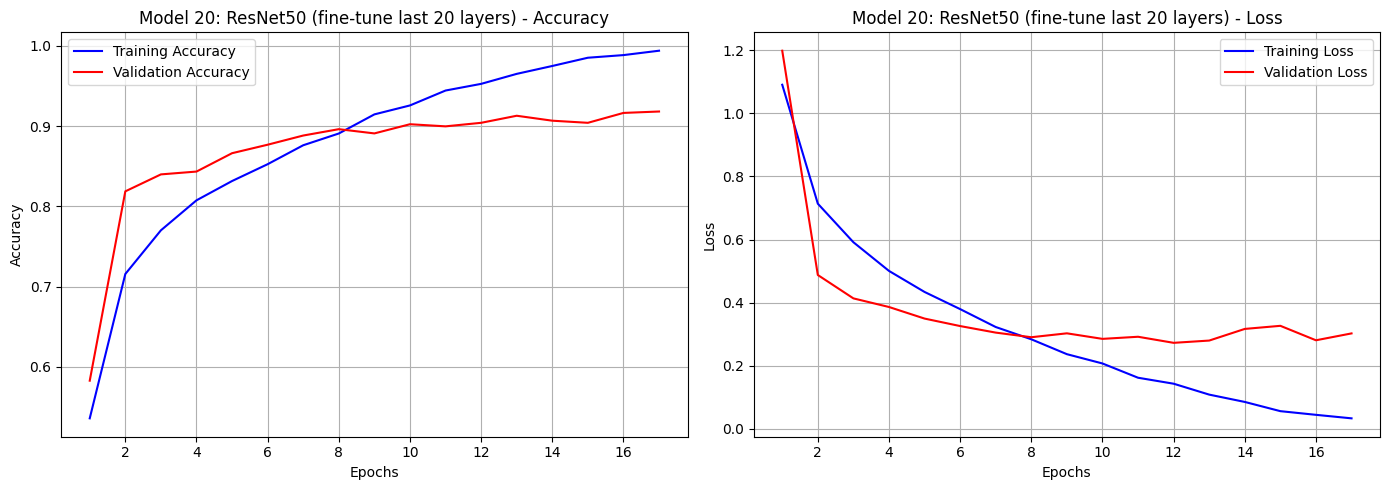

In [ ]:
from plot_utils import plot_training_curves
plot_training_curves(history20, 
                     model_name="Model 20: ResNet50 (fine-tune last 20 layers)")

**Confusion matrix plot**

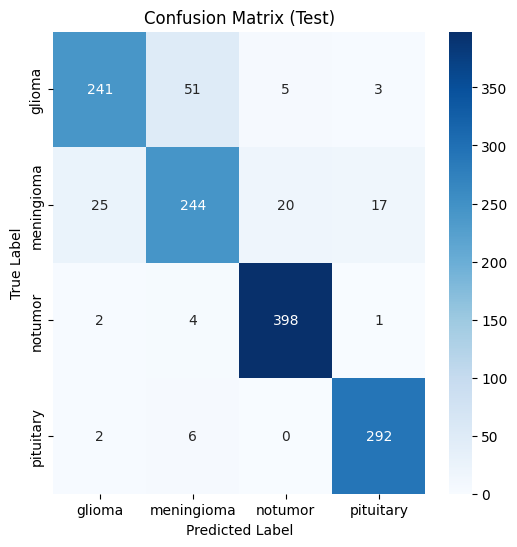


Classification Report:

              precision    recall  f1-score   support

      glioma       0.89      0.80      0.85       300
  meningioma       0.80      0.80      0.80       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.93      0.97      0.95       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.89      1311



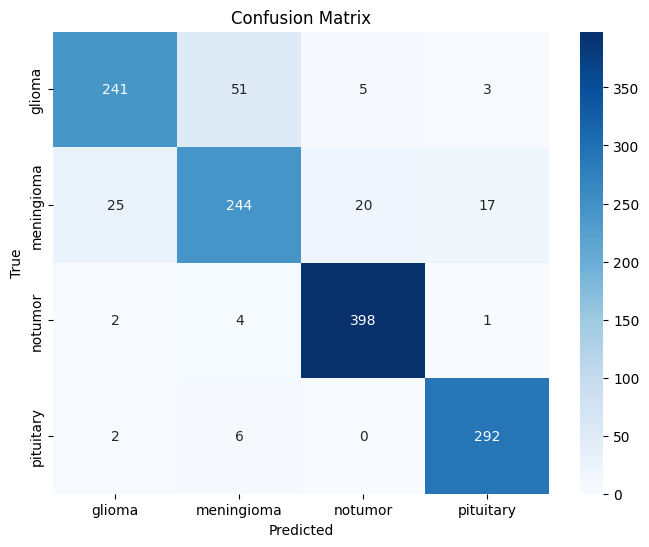


Classification Report:

              precision    recall  f1-score   support

      glioma       0.89      0.80      0.85       300
  meningioma       0.80      0.80      0.80       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.93      0.97      0.95       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.89      1311



In [11]:
from plot_utils import (
    plot_training_curves,
    evaluate_model_with_confusion,
    plot_confusion_matrix_from_dataset
)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix with in-memory model
evaluate_model_with_confusion(model20, test_ds, class_names, title="Confusion Matrix (Test)")

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model20_best.keras", test_ds, class_names)
